In [29]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import xesmf
import os
import matplotlib.font_manager as font_manager


In [30]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39231/status,
Dashboard: /proxy/39231/status,Workers: 7
Total threads: 28,Total memory: 125.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41425,Workers: 7
Dashboard: /proxy/39231/status,Total threads: 28
Started: Just now,Total memory: 125.21 GiB
Comm: tcp://127.0.0.1:33699,Total threads: 4
Dashboard: /proxy/38277/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:40821,


In [31]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [32]:
lat_slice  = slice(-82,-59)

In [33]:
expt = '01deg_jra55v13_ryf9091'

variable='ht'
ht = cc.querying.getvar(expt,'ht',master_session,n=1).sel(yt_ocean=lat_slice)
ht.load()

variable='geolon_t'
geolon_t = cc.querying.getvar(expt,variable,master_session, n=-1)#.sel(yt_ocean=lat_slice)
geolon_t.load()

variable='geolat_t'
geolat_t = cc.querying.getvar(expt,variable,master_session, n=-1)#.sel(yt_ocean=lat_slice)
geolat_t.load()

<xarray.DataArray 'geolat_t' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:     tracer latitude
    units:         degrees_N
    valid_range:   [-91.  91.]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration under the...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...

In [46]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1).fillna(0.0).sel(yt_ocean=lat_slice)
area_t.load();

In [35]:
iso = xr.open_dataset('/home/561/pas561/gdv45/jnb/misc/Antarctic_isobath_1000m.nc')

In [36]:
#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp, freq, ses, minlon, maxlon, minlat = -90, maxlat = -59):
    '''
    Inputs:
    var - Short name for the variable of interest
    start - Time from when data has to be returned
    end - Time until when data has to be returned
    exp - Experiment name
    freq - Time frequency of the data
    ses - Cookbook session
    minlat - minimum latitude from which to return data. If not set, defaults to min latitude in geolon_t data array.
    maxlat - maximum latitude from which to return data. If not set, defaults to max latitude in geolon_t data array.
    minlon - minimum longitude from which to return data. If not set, defaults to -90 to cover the Southern Ocean.
    maxlon - minimum longitude from which to return data. If not set, defaults to -45 to cover the Southern Ocean.

    Output:
    Data array with corrected time and coordinates within the specified time period and spatial bounding box.
    '''
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end, decode_coords = False)
    #Applying time correction
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(yt_ocean = slice(minlat, maxlat))
    return vararray

In [37]:
control = '01deg_jra55v13_ryf9091'

# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [38]:
#look at years 6-10
start_time='2155-01-01'
end_time='2159-12-31'

In [39]:
hi_m_con=getACCESSdata(var='hi_m',start=start_time,end=end_time,exp=control,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
hi_m_con=hi_m_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()

#http://www.ccpo.odu.edu/~klinck/Reprints/PDF/cicedoc2015.pdf
#note:The ice fraction ai (aice) is the total fractional ice coverage of a grid cell. That is, in each cell,
#ai = 0 if there is no ice
#ai = 1 if there is no open water
#0 < ai < 1 if there is both ice and open water

ai_m_con=getACCESSdata(var='aice_m',start=start_time,end=end_time,exp=control,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
ai_m_con=ai_m_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()


In [40]:
hi_m_up=getACCESSdata(var='hi_m',start=start_time,end=end_time,exp=easterlies_up,freq='1 monthly',
                      ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
hi_m_up=hi_m_up.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()

ai_m_up=getACCESSdata(var='aice_m',start=start_time,end=end_time,exp=easterlies_up,freq='1 monthly',
                      ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
ai_m_up=ai_m_up.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()


In [41]:
hi_m_dwn=getACCESSdata(var='hi_m',start=start_time,end=end_time,exp=easterlies_down,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
hi_m_dwn=hi_m_dwn.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()

ai_m_dwn=getACCESSdata(var='aice_m',start=start_time,end=end_time,exp=easterlies_down,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
ai_m_dwn=ai_m_dwn.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time').load()


In [42]:
uvel_up=getACCESSdata(var='uvel_m',start=start_time,end=end_time,exp=easterlies_up,freq='1 monthly',
                      ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
uvel_up = uvel_up.sel(time=slice(start_time,end_time)).mean('time').load()

vvel_up=getACCESSdata(var='vvel_m',start=start_time,end=end_time,exp=easterlies_up,freq='1 monthly',
                      ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
vvel_up = vvel_up.sel(time=slice(start_time,end_time)).mean('time').load()

uvel_dwn=getACCESSdata(var='uvel_m',start=start_time,end=end_time,exp=easterlies_down,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
uvel_dwn = uvel_dwn.sel(time=slice(start_time,end_time)).mean('time').load()

vvel_dwn=getACCESSdata(var='vvel_m',start=start_time,end=end_time,exp=easterlies_down,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
vvel_dwn = vvel_dwn.sel(time=slice(start_time,end_time)).mean('time').load()

uvel_con=getACCESSdata(var='uvel_m',start=start_time,end=end_time,exp=control,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
uvel_con = uvel_con.sel(time=slice(start_time,end_time)).mean('time').load()

vvel_con=getACCESSdata(var='vvel_m',start=start_time,end=end_time,exp=control,freq='1 monthly',
                       ses=master_session, minlon=geolon_t.xt_ocean.values.min(),maxlon=geolon_t.xt_ocean.values.max())
vvel_con = vvel_con.sel(time=slice(start_time,end_time)).mean('time').load()

In [43]:
ah_up=hi_m_up-hi_m_con

av_up=vvel_up-vvel_con

au_up=uvel_up-uvel_con

ah_dwn=hi_m_dwn-hi_m_con

av_dwn=vvel_dwn-vvel_con

au_dwn=uvel_dwn-uvel_con

In [52]:
#mask ice velocities where conc< threshold

conc_threshold = 0.4
au_dwn2 = au_dwn.where(ai_m_dwn>conc_threshold) 
av_dwn2 = av_dwn.where(ai_m_dwn>conc_threshold) 

au_up2 = au_up.where(ai_m_up>conc_threshold) 
av_up2 = av_up.where(ai_m_up>conc_threshold)

In [75]:
# regrid ice velocities so they're not so noisy:

# set up new bins:
lon_bins = np.arange(-280, 80, 5)
lat_bins = np.arange(-81, -59, .5) 
lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

#get lat/lon with correct mask:
geolon_t = (geolon_t*(ah_up*0+1))
geolat_t = (geolat_t*(ah_up*0+1))

# array to write into:
binned_au_up2 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'])
binned_av_up2 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'])
binned_au_dwn2 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'])
binned_av_dwn2 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'])

for i in range(len(lon_bins)-1):
    if i%10 == 0:
        print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = ht.where(ht.xt_ocean <= lon_bins[i+1]).where(ht.xt_ocean > lon_bins[i])\
            .where(ht.yt_ocean <= lat_bins[j+1]).where(ht.yt_ocean > lat_bins[j]) * 0 + 1
        binned_au_up2[j,i] = (au_up2 * bin_mask).mean('xt_ocean').mean('yt_ocean')
        binned_av_up2[j,i] = (av_up2 * bin_mask).mean('xt_ocean').mean('yt_ocean')
        binned_au_dwn2[j,i] = (au_dwn2 * bin_mask).mean('xt_ocean').mean('yt_ocean')
        binned_av_dwn2[j,i] = (av_dwn2 * bin_mask).mean('xt_ocean').mean('yt_ocean')

lon bin 0/71
lon bin 10/71
lon bin 20/71
lon bin 30/71
lon bin 40/71
lon bin 50/71
lon bin 60/71
lon bin 70/71


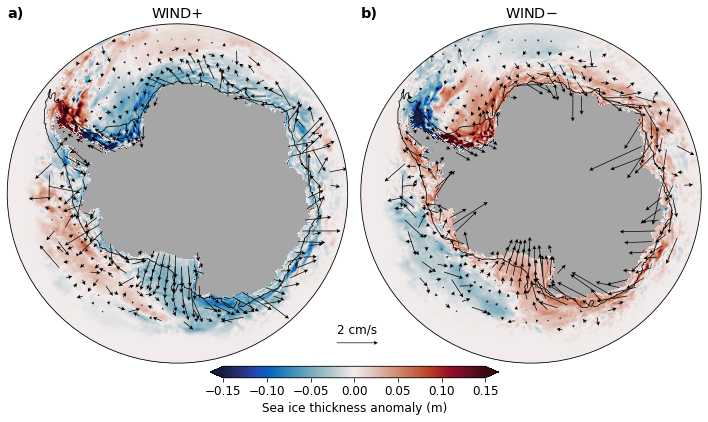

In [91]:
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(10, 8))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.65')
#ax = plt.gca()
ax.set_title('a)', loc='left', fontweight='bold')

ax.set_extent([-280, 80, -80, -62], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ah_up.plot.pcolormesh(x='xt_ocean', y='yt_ocean',vmin=-.15, vmax=.15, add_colorbar=False, 
                           cmap=cmocean.balance, extend='both', transform=ccrs.PlateCarree())

ax.plot(iso['x'], iso['y'], color = 'k', linewidth = 0.75, transform = ccrs.PlateCarree())

# using binned velocities:
count = 1
p2=ax.quiver(binned_au_up2.lon_bin, binned_au_up2.lat_bin[count::4], 
             binned_au_up2.values[count::4,:], binned_av_up2.values[count::4,:],
             scale_units='inches', scale=0.035,headwidth=6,headlength=6,headaxislength=5,width=.002,
             transform=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

tit='WIND+'
plt.title(tit)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.65')
ax.set_title('b)', loc='left', fontweight='bold')

ax.set_extent([-280, 80, -80, -62], crs=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ah_dwn.plot.pcolormesh(x='xt_ocean', y='yt_ocean',vmin=-.15, vmax=.15, add_colorbar=False, 
                            cmap=cmocean.balance, extend='both', transform=ccrs.PlateCarree())

ax.plot(iso['x'], iso['y'], color = 'k', linewidth = 0.75, transform = ccrs.PlateCarree())

# using binned velocities:
p2=ax.quiver(binned_au_up2.lon_bin, binned_au_up2.lat_bin[count::4], 
             binned_au_dwn2.values[count::4,:], binned_av_dwn2.values[count::4,:],
             scale_units='inches', scale=0.035,headwidth=6,headlength=6,headaxislength=5,width=.002,
             transform=ccrs.PlateCarree())

plt.quiverkey(p2,X=-.01,Y=0.06,U=0.02,label='2 cm/s')#,fontproperties=font)
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

tit='WIND$-$'
plt.title(tit)

ax_cb = plt.axes([.3, 0.18, 0.4, 0.02])
cb = plt.colorbar(p1,cax=ax_cb,orientation='horizontal', extend='both', shrink=0.5)
cb.ax.set_xlabel('Sea ice thickness anomaly (m)');
cb.ax.tick_params(labelsize=12) 
    
plt.tight_layout()

fig_path = '/g/data/v45/akm157/figures/easterlies/paper_figures/'
plt.savefig(fig_path + 'Figure7.png',bbox_inches = 'tight',dpi=250)